# Summary
---

### This section entails summary of analysis based on Bottle Rocket data. 

## Data Analysis
* February of 2015 saw the largest sign-up of users
* Roughly 4% of the spend are categorized as outliers and therefore may be erroneous
* After moving the outliers and looking at spend per month, users acquired in the winter of 2017 to 2018 saw a dip in spend per month
* Roughly 270k users are in the high spend bucket, defined as above 80th percentile

## Machine Learning
* Leveraging artificial neural network, the model is able to achieve approximately 99% accuracy in predicting whether a user will be a high spend user or not.
#### Characteristic of the model and training:
* 3 layers
* Batch size: 25
* Epochs: 500
* CV: 10-fold

# Jupyter Notebook Work Reference
---

# Section 1 
---

## 1.1 - How would you look at 10 statistical sample rows in this table?

```
SELECT
*
FROM page_table
LIMIT 10
```

## 1.2 - How would you look at unique visitor_id's who saw the ‘home page’ or the ‘checkout page’?

```
SELECT
COUNT(DISTINCT visitor_id)
FROM page_table
WHERE 1=1
AND page_name IN ('home page', 'product page')
```

## 1.3 - Get a list of the 100 visitors who saw the most unique pages.

```
SELECT
visitor_id,
COUNT(DISTINCT page_name) AS distinct_pages
FROM page_table
GROUP BY 1
ORDER BY distinct_pages DESC
LIMIT 100
```

# SECTION 2 - DATA PROCESSING / ANALYSIS / MACHINE LEARNING / DATA VISUALIZATION
---

## Data Preparation

In [1]:
import pandas as pd
import numpy as np

# Importing dataset
dataset = pd.read_csv('retina-bottlerocket_2018-03-27-1745.csv')

print("Describe the dataset")
dataset.describe()

print("# Of customers: ", dataset['customer_id'].count())

Describe the dataset
# Of customers:  1419335


/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4234: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


## 2.1 - Plot the number of customers who joined by month

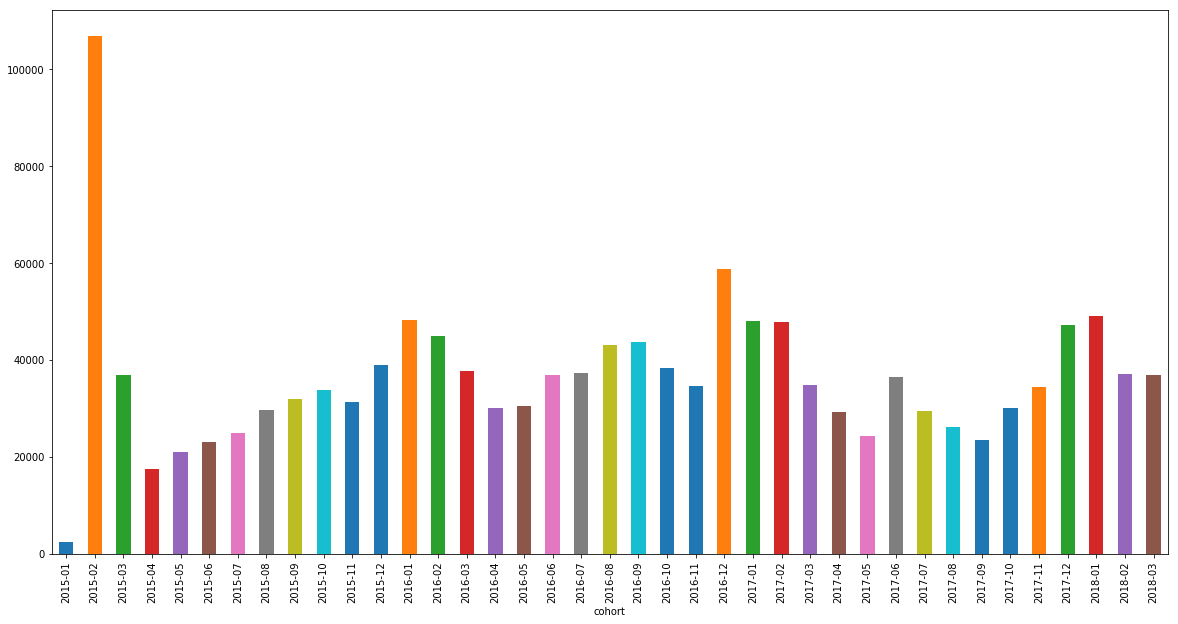

In [30]:
joins_by_date = dataset.groupby(['cohort'])['cohort'].count()

# print(joins_by_date)
joins_by_date.plot(x='Join Date', kind='bar', figsize=(20,10))

## 2.2 - It looks like some customers have potentially erroneous data when we look at their total spend. Are they statistically significant?

In [3]:
# Check for how many outliers there are (> 1.5 IQR)
q1 = dataset['total_revenue'].quantile(0.25)
q3 = dataset['total_revenue'].quantile(0.75)
iqr = q3 - q1

# Get total number of data
samples = dataset['total_revenue'].count()

# Get the count of outliers
outliers = dataset['total_revenue'][dataset['total_revenue']>q3+1.5*iqr].count() + dataset['total_revenue'][dataset['total_revenue']<q1-1.5*iqr].count()
print(outliers/samples*100)

4.1207325966


* I am guessing that the incorrect data entered may be outliers. In this case, if we are to look at outliers defined as 1.5*IQR beyond Q3 and below Q1, we find that roughly 4% of the data are outliers. Since it is less than 5%, I do not think that it is significant.

## 2.3 - Remove the outlier(s) from (2.2) and plot the histogram of Average Revenue Per Month. What insights can you glean from this plots?

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


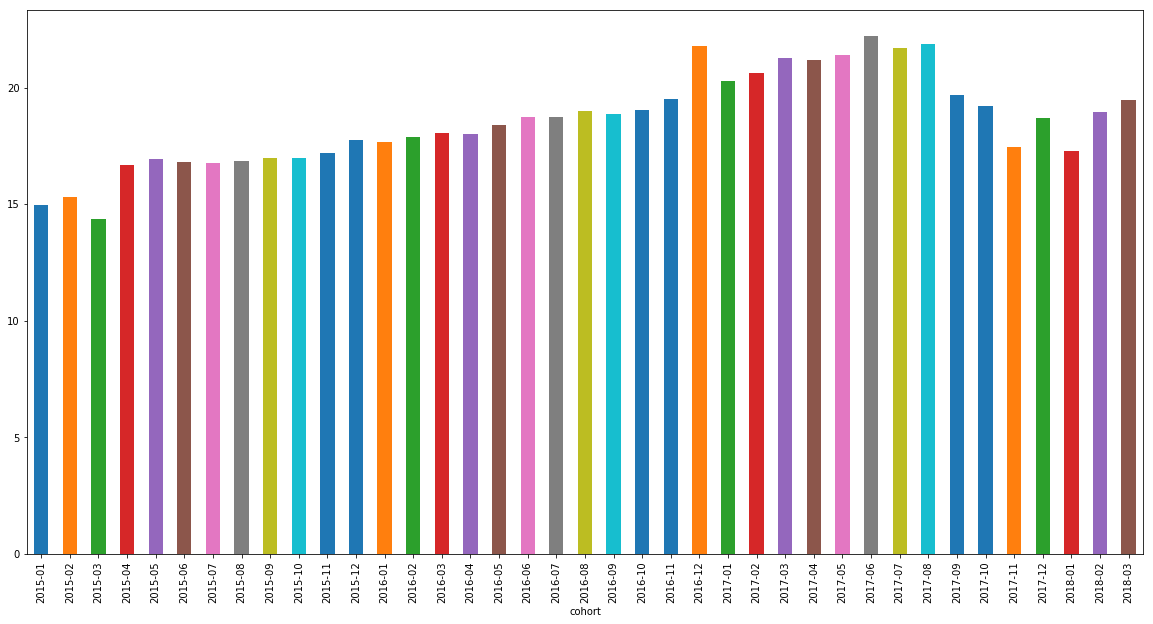

In [4]:
filtered = dataset.query('(@q1 - 1.5 * @iqr) <= total_revenue <= (@q3 + 1.5 * @iqr)')
filtered['avg_month_spend'] = dataset.apply(lambda row: row.total_revenue/row.duration_in_months, axis=1)
avg_by_cohort = filtered.groupby('cohort')['avg_month_spend'].mean()
avg_by_cohort.plot(x='Cohort', y='Average Total Revenue', kind='bar', figsize=(20,10))

### Insights

* The customer acquired are spending more and more per month up until 2017-05. However this could be due to novelty effect.
* The customers who signed up during the winter season in 2017 to 2018 seemed to spend less per month.

## 2.4 - Now, define a new boolean variable “high value customer” based on if the average spend per month is the top 80th percentile. How many customers fall in the high value customer bucket?

In [32]:
percentile_80 = filtered['total_revenue'].quantile(0.80)
filtered['high_val_cust'] = dataset.apply(lambda row: 1 if row.total_revenue > percentile_80 else 0, axis=1)
high_val_cust_count = filtered[filtered.high_val_cust == 1]['high_val_cust'].count()
print(high_val_cust_count)

270440


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


* About 270k of customers are high valued customers.

## 2.5 - Build a machine learning model [using anything but linear or logistic regression] to come up with a ranked list of features/independent variables that correlate with your definition of high value customers. Include all analysis, plots, and tables to show your work. Include plots showing how these variables predict/determine high value customers. (hint: You may want to include AUC/ROC curves).

Use this ranked list to answer the business question: “what are the most important variables which predict/determine high value customers?”. Also include discussion of the strengths and weaknesses of using this approach vs potential alternate approaches.

In [7]:
#!/usr/bin/env python
from __future__ import print_function

import os
import json
import pickle
import sys
import traceback

from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout, Dense


DIM = len(filtered.columns)
CATEGORICAL_VARIABLES = [
    'customer_id',
    'bundle_acquisition',
    'signup_android',
    'payment_card_brand',
    'payment_card_method',
    'customer_gender',
    'original_payment_card_type',
    'customer_marital_status',
    'unsubscribed',
    'original_plan',
    'ad_channel',
    'ad_channel',
    'current_plan',
    'customer_surveyed',
    'bank_name',
    'city',
    'zip_code',
    'channel',
    'promotion',
    'cohort',
    'age_bucket',
    'high_val_cust'
]

# Process and prepare the data
def data_process(raw_data):
    # train_data = pd.concat(raw_data) # Used for having multiple df
    train_data = raw_data
    for cat_cols in train_data.columns:
        if train_data[cat_cols].dtype == "object":
            train_data[cat_cols] = train_data[cat_cols].astype('category').cat.codes
        
    #     for col in train_data.columns:
    #         if col not in CATEGORICAL_VARIABLES:
    #             col_mean = np.nanmean(train_data[col], axis=0)
    #             train_data[col].fillna(col_mean, inplace=True)

    # Replace with average age
    X = train_data.iloc[:, 1:len(raw_data.columns)-1].values
    y = train_data.iloc[:, len(raw_data.columns)-1].values

    # Encoding categorical variables
    labelencoder_X_1 = LabelEncoder()
    for categorical_col in CATEGORICAL_VARIABLES:
        X[:, train_data.columns.get_loc(categorical_col)-2] = labelencoder_X_1.fit_transform(X[:, train_data.columns.get_loc(categorical_col)-2])

    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.25,
        random_state=0)

    # Feature Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)

    return X_train, X_test, y_train, y_test


# Building the ANN
def build_classifier(optimizer):
    # Initialize ANN
    classifier = Sequential()

    # First hidden layer with 10% dropout
    classifier.add(Dense(
        activation="relu",
        input_dim=60,
        units=30,
        kernel_initializer="uniform"))
    classifier.add(Dropout(rate=0.2))

    # The second hidden layer with 10% dropout
    classifier.add(Dense(
        activation="relu",
        units=30,
        kernel_initializer="uniform"))
    classifier.add(Dropout(rate=0.2))

    # Adding the output layer
    classifier.add(Dense(
        activation="sigmoid",
        units=1,
        kernel_initializer="uniform"))

    # Compiling the ANN
    classifier.compile(
        optimizer=optimizer, # efficient SGD
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return classifier


def generate_model(X_train, y_train):
    # Build classifier using grid search
    classifier = KerasClassifier(build_fn=build_classifier)

    # Create a dict of hyperparameters to optimize
    parameters = {
        # Tune batch size, epoch, optimizer
        'batch_size': [25, 32],
        'nb_epoch': [100, 500],
        'optimizer': ['adam', 'rmsprop']
    }

    # Implement GridSearch
    grid_search = GridSearchCV(
        estimator=classifier,
        param_grid=parameters,
        scoring='accuracy',
        cv=10
    )

    # Fit gridsearch to training set
    optimized_classifier = grid_search.fit(
        X_train,
        y_train
    )

    return optimized_classifier


def train():
    X_train, X_test, y_train, y_test = data_process(filtered)
    optimized_classifier = generate_model(X_train, y_train)
    return X_test, y_test, optimized_classifier
    
X_test, y_test, optimized_classifier = train()

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
918572/918572 [==============================] - 97s 106us/step - loss: 0.0265 - acc: 0.9898
Epoch 1/1
918572/918572 [==============================] - 95s 104us/step - loss: 0.0268 - acc: 0.9896
Epoch 1/1
918572/918572 [==============================] - 93s 101us/step - loss: 0.0265 - acc: 0.9897
Epoch 1/1
918572/918572 [==============================] - 98s 107us/step - loss: 0.0260 - acc: 0.9897
Epoch 1/1
918572/918572 [==============================] - 95s 104us/step - loss: 0.0270 - acc: 0.9896
Epoch 1/1
918572/918572 [==============================] - 101s 110us/step - loss: 0.0273 - acc: 0.9895
Epoch 1/1
918573/918573 [==============================] - 100s 109us/step - loss: 0.0271 - acc: 0.9896
Epoch 1/1
918573/918573 [==============================] - 95s 104us/step - loss: 0.0266 - acc: 0.9897
Epoch 1/1
918573/918573 [==============================] - 98s 106us/step - loss: 0.0282 - acc: 0.9890
Epoch 1/1
918573/918573 [==============================] - 98s 107us/st

1020636/1020636 [==============================] - 120s 118us/step - loss: 0.0255 - acc: 0.9899


In [10]:
from sklearn.metrics import roc_auc_score

# Make predictions
y_pred = optimized_classifier.predict(X_test)

# If y_pred is > 0.5 then true, else false
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Get best params and info
best_parameters = optimized_classifier.best_params_
best_accuracy = optimized_classifier.best_score_
print("Best parameters: ", best_parameters)
print("Best accuracy: ", best_accuracy)

[[272219    568]
 [  1214  66211]]
Best parameters:  {'batch_size': 25, 'nb_epoch': 500, 'optimizer': 'adam'}
Best accuracy:  0.994522043118


### Plotting ROC/AUC Curive

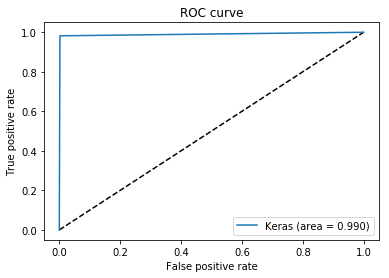

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

plt.figure(0).clf()
fpr, tpr, thresh = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()